In [1]:
import nibabel as nib
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
import cv2
import random
import matplotlib.pyplot as plt
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import zoom
from glob import glob
from PIL import Image
from tqdm import tqdm
from torch.utils.data import random_split
from torch.utils.data import Subset, DataLoader
from torchsummary import summary

torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True

## Data Processing and Exploration

### Choosing the right data:

The full dataset has been processed from it's original 350GB+ MRI dataset. The original csv file is filtered to include only 1.5T or 3.0T scans as they contain the most comprehensive sets of MRI scans of differing types (T1-weighted, T2, Bold, etc). 

The clinical dementia rating (cdr) with values (0, 0.5, 1, 2) represent 0 = absent; 0.5 = questionable; 1= present, but mild; 2 = moderate (reference: https://www.sciencedirect.com/topics/neuroscience/clinical-dementia-rating). They have been remapped from (0, 0.5, 1, 2) to (0, 1, 2, 3) due to issues processing it with Torch dataloader, leading to a missing class for 0.5 cdr.

Based on each MRI session value (Label), if there are multiple values for the cdr then the scans are excluded.

In [2]:
diagnostic_file = glob('diagnosis.csv')[0]

diagnostic_df = pd.read_csv(diagnostic_file)

diagnostic_df = diagnostic_df[(diagnostic_df.Scanner == '3.0T') | (diagnostic_df.Scanner == '1.5T')]

multiple_values = diagnostic_df.groupby('Label').filter(lambda group: group['cdr'].nunique() > 1)['Label'].unique()

cdr_map = {0.0: 0, 0.5: 1, 1.0: 2, 2.0: 3}

# Filter out rows with these values in column A
filtered_diagnostic_df = diagnostic_df[~diagnostic_df['Label'].isin(multiple_values)]
filtered_diagnostic_df = filtered_diagnostic_df.drop_duplicates(subset='Label')
# filtered_diagnostic_df['cdr'] = filtered_diagnostic_df['cdr'].map(cdr_map)
filtered_diagnostic_df['file_tag'] = filtered_diagnostic_df.Label.apply(lambda file_name: file_name[-5:])
print(len(filtered_diagnostic_df))

valid_mr_scans_ls = filtered_diagnostic_df.file_tag.to_list()
print(valid_mr_scans_ls[:3])
filtered_diagnostic_df.file_tag

# filtered_diagnostic_df.to_csv('filtered_data.csv')

1379
['d0129', 'd2430', 'd3132']


0       d0129
2       d2430
3       d3132
12      d0371
15      d2340
        ...  
6193    d0148
6194    d2526
6195    d1566
6216    d1717
6217    d0407
Name: file_tag, Length: 1379, dtype: object

This section is to preview the different MRI images available.

['sub-OAS30001_ses-d0757_acq-TSE_T2w.nii.gz', 'sub-OAS30001_ses-d0757_run-01_T1w.nii.gz', 'sub-OAS30001_ses-d0757_run-02_T1w.nii.gz', 'sub-OAS30001_ses-d0757_T2star.nii.gz', 'sub-OAS30001_ses-d0757_T2w.nii.gz', 'sub-OAS30001_ses-d0757_dwi.nii.gz', 'sub-OAS30001_ses-d0757_task-rest_run-01_bold.nii.gz', 'sub-OAS30001_ses-d0757_task-rest_run-02_bold.nii.gz', 'sub-OAS30001_ses-d0757_minIP.nii.gz', 'sub-OAS30001_ses-d0757_swi.nii.gz']


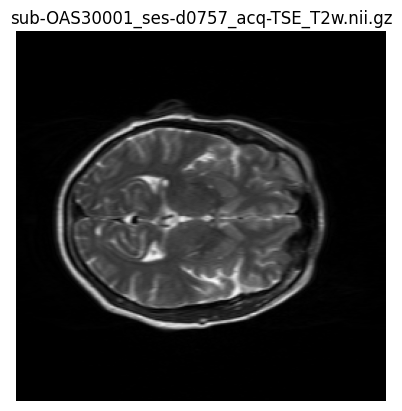

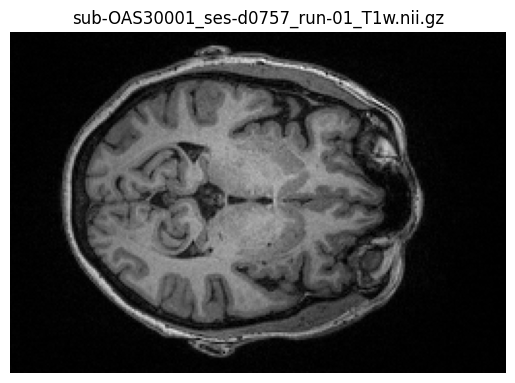

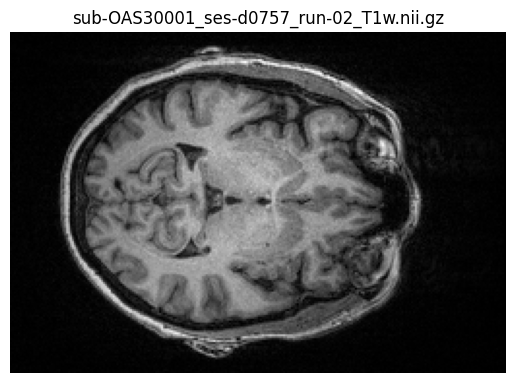

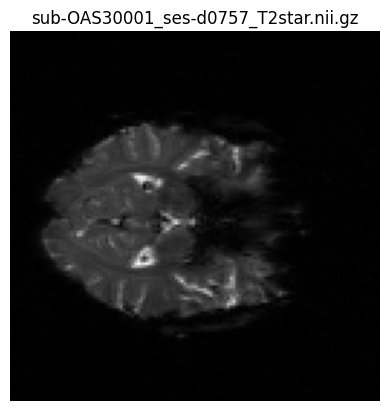

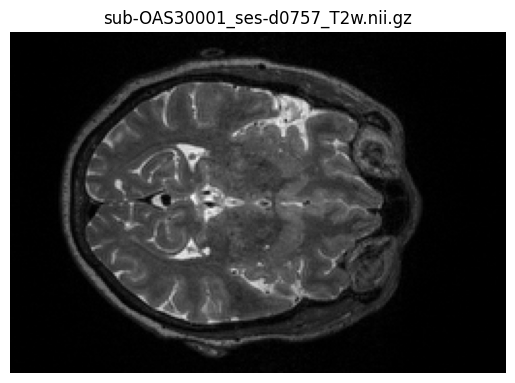

Cannot show: D:/DL/bids/sub-OAS30001/ses-d0757\dwi\sub-OAS30001_ses-d0757_dwi.nii.gz
Cannot show: D:/DL/bids/sub-OAS30001/ses-d0757\func\sub-OAS30001_ses-d0757_task-rest_run-01_bold.nii.gz
Cannot show: D:/DL/bids/sub-OAS30001/ses-d0757\func\sub-OAS30001_ses-d0757_task-rest_run-02_bold.nii.gz


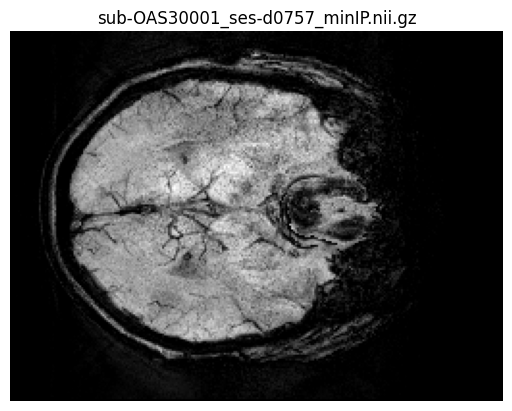

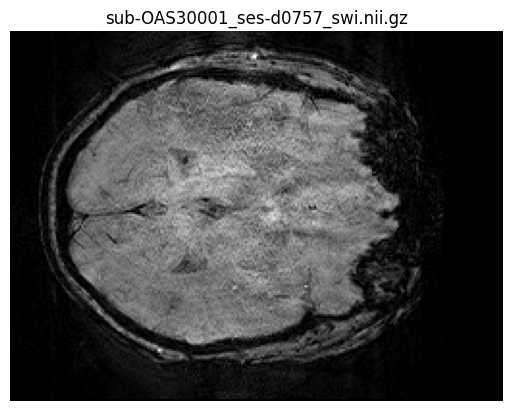

In [3]:
def display_nii_gz_files(file_path):
    # List all files in the given directory
    nii_gz_files = glob(file_path + '/**/*nii.gz', recursive=True)
    
    file_names = [file.split('\\')[-1] for file in nii_gz_files]
    print(file_names)
    # Display each .nii.gz file
    for file_name in nii_gz_files:
        try:
            img = nib.load(file_name)
            data = img.get_fdata()
            
            # Display a middle slice of the 3D image
            slice_index = data.shape[2] // 2
            plt.imshow(data[:, :, slice_index], cmap='gray')
            plt.title(file_name.split('\\')[-1])
            plt.axis('off')
            plt.show()
        except:
            print(f'Cannot show: {file_name}')

# Example usage
display_nii_gz_files('D:/DL/bids/sub-OAS30001/ses-d0757/')


Based on research, T1-weighted scans are one of the most widely used datasets for predicting and diagnosing dementia. It provides extremely detailed assessments of the brain's structure which can be used to find out the presence or absence, as well as the pattern for brain volume loss such as atrophy. Hence, below is the file retrieval for T1-weighted scans.

Reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3486423/#:~:text=T1%20weighted%20volumetric%20MRI%20scanning,volume%20loss%2C%20ie%2C%20atrophy.

In [4]:
data_path = 'D:/DL/bids/' ## Change as needed

def recursive_glob_with_filter(directory, filter_list):
    # Use recursive glob pattern to find all files
    all_files = glob(directory + '/**/*T1*nii.gz', recursive=True)
    
    # Filter files based on the presence of strings from filter_list in the file path
    filtered_files = [file for file in all_files if any(filter_str in file for filter_str in filter_list)]
    
    return filtered_files

file_ls = recursive_glob_with_filter(data_path, valid_mr_scans_ls)
print(file_ls[:2])

['D:/DL/bids\\sub-OAS30001\\ses-d0129\\anat\\sub-OAS30001_ses-d0129_run-01_T1w.nii.gz', 'D:/DL/bids\\sub-OAS30001\\ses-d0129\\anat\\sub-OAS30001_ses-d0129_run-02_T1w.nii.gz']


In [5]:
# from nilearn import plotting

# nifti_file_path = file_ls[8]
# img = nib.load(nifti_file_path)
# data = img.get_fdata()

# # Display a single slice
# scan = data[:, :, data.shape[2] // 2]
# plt.imshow(data[:, :, data.shape[2] // 2], cmap='gray')
# plt.show()
# print(scan.shape) #(176, 256, 256)
# plt.imshow(scan)

# # Display the anatomical image
# plotting.plot_anat(nifti_file_path)
# plotting.show()

# # Interactive plotting
# plotting.view_img(img, bg_img=False, cmap='gray')

# # Plotting multiple slices
# plotting.plot_anat(nifti_file_path, display_mode='ortho', cut_coords=(30, -40, 10), cmap='gray')


In [6]:
# Function to extract tag from file path
def extract_tag_from_file_path(file_path):
    file_path = file_path.replace(data_path[:-1], '')
    return file_path.split('\\')[2][-5:]

try:
    data_loader_df = pd.read_csv('data_loader_df.csv')
except:
    # Create a new DataFrame to store the results
    data_loader_df = pd.DataFrame(columns=['file_path', 'label'])

    # Iterate over the file list and find the corresponding CDR value
    for file_path in file_ls:
        tag = extract_tag_from_file_path(file_path)
        cdr_value = filtered_diagnostic_df.loc[filtered_diagnostic_df['file_tag'] == tag, 'cdr'].values
        if cdr_value.size > 0:  # Check if cdr_value is not empty
            new_row = pd.DataFrame({'file_path': [file_path], 'label': [cdr_value[0]]})
            data_loader_df = pd.concat([data_loader_df, new_row], ignore_index=True)
            data_loader_df.to_csv('data_loader_df.csv')

print(data_loader_df)

      Unnamed: 0                                          file_path  label
0              0  D:/DL/oasis-scripts/download_scans/bids\sub-OA...    0.0
1              1  D:/DL/oasis-scripts/download_scans/bids\sub-OA...    0.0
2              2  D:/DL/oasis-scripts/download_scans/bids\sub-OA...    0.0
3              3  D:/DL/oasis-scripts/download_scans/bids\sub-OA...    0.0
4              4  D:/DL/oasis-scripts/download_scans/bids\sub-OA...    0.0
...          ...                                                ...    ...
2991        2991  D:/DL/oasis-scripts/download_scans/bids\sub-OA...    0.0
2992        2992  D:/DL/oasis-scripts/download_scans/bids\sub-OA...    1.0
2993        2993  D:/DL/oasis-scripts/download_scans/bids\sub-OA...    0.0
2994        2994  D:/DL/oasis-scripts/download_scans/bids\sub-OA...    0.5
2995        2995  D:/DL/oasis-scripts/download_scans/bids\sub-OA...    0.0

[2996 rows x 3 columns]


This section is to extract 2D slices from 3D volumetric MRI scans. It iterates through the T1-weighted scans and slices between indexes 100-160, choosing a slice for every 3 slices. If the scan has less then 160 slices, then the middle slice will be taken of which there is only 1. Eventually there should be a dataset of 58,376. 

JPG is the saved file format due to its smaller size. NPY was tried but was 840GB and hence rejected.

**Run only once (roughly 7-20 mins depending on CPU).**

In [7]:
'''## For image generation. Please do not delete

# Define the mapping from old labels to new labels
label_mapping = {0.0: 0, 0.5: 1, 1.0: 2, 2.0: 3}

# Apply the mapping to the 'label' column
data_loader_df['label'] = data_loader_df['label'].map(label_mapping)

def img_preprocessing(img):
    # Normalize the image
    normalized_image = (img - np.min(img)) / (np.max(img) - np.min(img))

    # Determine the scaling factor based on the longest edge
    scaling_factor = 224 / max(normalized_image.shape)
    rescaled_size = (int(normalized_image.shape[1] * scaling_factor), int(normalized_image.shape[0] * scaling_factor))
    rescaled_image = cv2.resize(normalized_image, rescaled_size, interpolation=cv2.INTER_LINEAR)

    # Calculate padding sizes
    pad_height = (224 - rescaled_image.shape[0]) // 2
    pad_width = (224 - rescaled_image.shape[1]) // 2

    # Pad the image to 224x224
    padded_image = np.pad(rescaled_image, ((pad_height, 224 - rescaled_image.shape[0] - pad_height), (pad_width, 224 - rescaled_image.shape[1] - pad_width)), 'constant', constant_values=0)

    # Convert to RGB by repeating the single channel 3 times
    rgb_image = np.repeat(padded_image[:, :, np.newaxis], 3, axis=2)

    return rgb_image

def preprocess_and_save(df, save_dir):
    for i in range(len(df)):
        nifti_file_path, label = df.iloc[i]
        img = nib.load(nifti_file_path)
        data = img.get_fdata()

        try:
            for slice_index in range(100, 161, 3):  # Save slices from 100 to 160
                scan = data[:, :, slice_index]
                preprocessed_scan = img_preprocessing(scan)
                save_path = os.path.join(save_dir, f"label_{label}_idx_{i}_slice_{slice_index}.jpg")
                cv2.imwrite(save_path, preprocessed_scan * 255)  # Multiply by 255 to convert from [0, 1] to [0, 255] range

        except:
            scan = data[:, :, data.shape[2] // 2]
            preprocessed_scan = img_preprocessing(scan)
            save_path = os.path.join(save_dir, f"label_{label}_idx_{i}.jpg")
            cv2.imwrite(save_path, preprocessed_scan * 255)  # Multiply by 255 to convert from [0, 1] to [0, 255] range

save_dir = data_path[:-5] + "preprocessed_images"
print(save_dir)
os.makedirs(save_dir, exist_ok=True)
preprocess_and_save(data_loader_df, save_dir)
'''

'## For image generation. Please do not delete\n\n# Define the mapping from old labels to new labels\nlabel_mapping = {0.0: 0, 0.5: 1, 1.0: 2, 2.0: 3}\n\n# Apply the mapping to the \'label\' column\ndata_loader_df[\'label\'] = data_loader_df[\'label\'].map(label_mapping)\n\ndef img_preprocessing(img):\n    # Normalize the image\n    normalized_image = (img - np.min(img)) / (np.max(img) - np.min(img))\n\n    # Determine the scaling factor based on the longest edge\n    scaling_factor = 224 / max(normalized_image.shape)\n    rescaled_size = (int(normalized_image.shape[1] * scaling_factor), int(normalized_image.shape[0] * scaling_factor))\n    rescaled_image = cv2.resize(normalized_image, rescaled_size, interpolation=cv2.INTER_LINEAR)\n\n    # Calculate padding sizes\n    pad_height = (224 - rescaled_image.shape[0]) // 2\n    pad_width = (224 - rescaled_image.shape[1]) // 2\n\n    # Pad the image to 224x224\n    padded_image = np.pad(rescaled_image, ((pad_height, 224 - rescaled_image.shap

Due to an extremely imbalanced dataset (Label 0.0: 50216; Label 1.0: 5748; Label 2.0: 1971; Label 3.0: 441), weights will be used. 

In [8]:
from collections import defaultdict
import os
import pandas as pd
import torch

save_dir = data_path[:-5] + "preprocessed_images"
# Dictionary to store the count of each label
class_counts = defaultdict(int)

# List to store file paths and labels
file_paths_labels = []

# Iterate over all files in the save directory
for filename in os.listdir(save_dir):
    if filename.startswith("label_") and filename.endswith(".jpg"):
        # Extract the label from the filename and convert it to a decimal (float)
        label = float(filename.split("_")[1])
        # Increment the count for this label
        class_counts[label] += 1
        # Append the full file path and label to the list
        full_path = os.path.join(save_dir, filename)
        file_paths_labels.append((full_path, label))

# Print the count of each label
for label, count in class_counts.items():
    print(f"Label {label}: {count}")

# Create a DataFrame from the list of file paths and labels
jpg_data_loader_df = pd.DataFrame(file_paths_labels, columns=['file_path', 'label'])

## Print the first few rows of the DataFrame
# print(jpg_data_loader_df.head())

# Calculate weights: Inverse of the frequency seems like a simple choice
total_count = sum(class_counts.values())
weights = {k: total_count / v for k, v in class_counts.items()}
print(weights)
# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Convert weights to a tensor, ensuring the labels are in the correct order
weights_tensor = torch.tensor([weights[0], weights[1], weights[2], weights[3]], dtype=torch.float32)

print(weights_tensor)
weights_tensor = weights_tensor.to(device)
jpg_data_loader_df.to_csv('jpg_data_loader_df.csv')


Label 0.0: 50216
Label 1.0: 5748
Label 2.0: 1971
Label 3.0: 441
{0.0: 1.1624980086028358, 1.0: 10.155880306193458, 2.0: 29.617453069507864, 3.0: 132.3718820861678}
tensor([  1.1625,  10.1559,  29.6175, 132.3719])


## Functions

Functions for training the model. Includes NiftiDataset, HierarchicalCrossEntropyLoss, load_model, train_model and evaluate_model.

In [9]:
from torch.utils.data import DataLoader, random_split

class NiftiDataset(Dataset):
    def __init__(self, dataframe, preprocessed_dir):
        self.dataframe = dataframe
        self.preprocessed_dir = preprocessed_dir

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        label = row['label']
        img_path = row['file_path']  # Use the exact path from the dataframe
        scan = cv2.imread(img_path)
        # scan = cv2.resize(scan, (224,224), interpolation=cv2.INTER_LINEAR)
        scan = scan / 255.0  # Normalize the image to [0, 1]
        scan_tensor = torch.from_numpy(scan).float()
        
        # If the image is grayscale, we use unsqueeze to add the channel dimension
        if len(scan.shape) == 2:
            scan_tensor = scan_tensor.unsqueeze(0)  # Add channel dimension for grayscale image
        else:
            scan_tensor = scan_tensor.permute(2, 0, 1)  # Rearrange dimensions for color image
        
        label_tensor = torch.tensor(label).long()

        return scan_tensor, label_tensor

dataset = NiftiDataset(jpg_data_loader_df, preprocessed_dir=save_dir)

# Create a list of labels for stratified splitting
labels = jpg_data_loader_df.iloc[:, 1].values
myset = set(labels)
print(myset)

# Define the ratios for splitting
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Calculate the sizes for each split
total_size = len(dataset)
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_test_dataset = random_split(dataset, [train_size, val_size + test_size])
val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])

# Create dataloaders for each split
batch_size = 32  # Adjust the batch size as needed
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to count labels in a dataset
def count_labels(dataset):
    label_counts = {}
    for _, label_tensor in dataset:
        label = label_tensor.item()
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1
    return label_counts

# Print the sizes and label counts of each split
print(f'Train set size: {len(train_dataloader.dataset)}')
# print(f'Train set label count: {count_labels(train_dataloader.dataset)}')
print(f'Validation set size: {len(val_dataloader.dataset)}')
# print(f'Validation set label count: {count_labels(val_dataloader.dataset)}')
print(f'Test set size: {len(test_dataloader.dataset)}')
# print(f'Test set label count: {count_labels(test_dataloader.dataset)}')

{0.0, 1.0, 2.0, 3.0}
Train set size: 40863
Validation set size: 11675
Test set size: 5838


In [10]:
def load_model(model, model_name, model_type='best'):
    if model_type=='best':
        model_path = os.path.join('checkpoints/', f'best_{model_name}.pth')
    else:
        model_path = os.path.join(glob('checkpoints/' + f'{model_name}_epoch_*.pth')[-1])
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint)
    
    return model

### Specialised Loss Function

Given the imbalanced dataset, the first main classification would be to distinguish healthy patients from dementia patients. Once the dementia patients are found, weights are applied to penalize the classes with smaller datasets (which happen to be the more severe cases). Hence, HierarchicalCrossEntropyLoss is structured in the above manner to help models focus better on tackling the issue.

In [11]:
class HierarchicalCrossEntropyLoss(nn.Module):
    def __init__(self, weight):
        super(HierarchicalCrossEntropyLoss, self).__init__()
        # Expecting a tensor of weight of size 4, one for each class
        self.weight = weight

    def forward(self, logits, targets):
        # Binary classification loss: healthy vs all types of dementia
        healthy_dementia_targets = (targets > 0).long()
        # Use the first weight for healthy and the average of the remaining weight for all dementia
        all_dementia_weight = torch.mean(self.weight[1:]).item()
        binary_weight = torch.tensor([self.weight[0].item(), all_dementia_weight], device=self.weight.device)
        healthy_dementia_loss = F.cross_entropy(logits[:, :2], healthy_dementia_targets, weight=binary_weight)

        # Multi-class classification loss within dementia
        dementia_mask = targets > 0
        dementia_logits = logits[dementia_mask, 1:]  # Logits for dementia classes only
        dementia_targets = targets[dementia_mask] - 1
        # Use the specific weight for each type of dementia if there are any samples
        dementia_loss = (F.cross_entropy(dementia_logits, dementia_targets, weight=self.weight[1:])
                         if dementia_mask.any() else 0)

        # Combine the two losses
        total_loss = healthy_dementia_loss + dementia_loss
        return total_loss


In [12]:
def train_model(model, transform=None, num_epochs=15, model_name='model', training=False):
    best_val_accuracy = 0
    best_model = None

    model.train()
    model.to(device)

    checkpoint_path = os.path.join('checkpoints/', f'best_{model_name}.pth')
    if not training and os.path.exists(checkpoint_path):
        print(f"Checkpoint found for {model_name}. Loading checkpoint...")
        model = load_model(model, model_name)
        model.eval()  # Set the model to evaluation mode
        return model
    
    if training and os.path.exists(checkpoint_path):
        print(f"Checkpoint found for {model_name}. Loading checkpoint...")
        model = load_model(model, model_name)

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        # Training loop
        torch.manual_seed(42)
        progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}')
        for inputs, labels in progress_bar:
            if transform is not None:
                inputs = transform(inputs)
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            if hasattr(outputs, 'aux_logits'):
                outputs = outputs.logits

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_dataloader)
        train_accuracy = correct_predictions / total_predictions

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_predictions = 0

        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)

                if hasattr(outputs, 'aux_logits'):
                    outputs = outputs.logits

                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total_predictions += labels.size(0)
                val_correct_predictions += (predicted == labels).sum().item()

        val_loss /= len(val_dataloader)
        val_accuracy = val_correct_predictions / val_total_predictions

        print(f'Epoch {epoch + 1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}')

        # Save model for each epoch
        epoch_model_path = os.path.join('checkpoints/', f'{model_name}_epoch_{epoch + 1}.pth')
        torch.save(model.state_dict(), epoch_model_path)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model
            best_model_path = os.path.join('checkpoints/', f'best_{model_name}.pth')
            torch.save(model.state_dict(), best_model_path)

        model.train()

    print('Finished Training')
    return best_model

In [13]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score

def evaluate_model(model, dataloader, device, transform=None):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        torch.manual_seed(42) 
        for inputs, labels in dataloader:
            if transform is not None:
                inputs = transform(inputs)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            # Check if the output includes auxiliary logits
            if hasattr(outputs, 'aux_logits'):
                outputs = outputs.logits

            _, predictions = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Calculate overall accuracy
    accuracy = accuracy_score(all_labels, all_predictions)

    # Calculate class-specific accuracies
    cm = confusion_matrix(all_labels, all_predictions)
    print(cm)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)

    # Calculate F1 score, recall, and precision
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    del inputs
    del labels

    return accuracy, class_accuracies, f1, recall, precision

## Training models

### Benchmark models

For benchmarking, ResNet, VIT_small_patch16_224 and InceptionV3 will be used to compare against.

In [14]:
##Train
# Load the ResNet model
model = models.resnet18()
summary(model, (3, 224, 224))

# Modify the final layer to output 5 logits
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)

## Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss(weight=weights_tensor)
# Use the hierarchical cross-entropy loss function
criterion = HierarchicalCrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-5)
model = train_model(model, model_name='resnet18', num_epochs=15)


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]          --
|

Epoch 1/15: 100%|██████████| 1277/1277 [01:03<00:00, 20.14it/s]


Epoch 1, Train Loss: 1.3585397322007988, Train Accuracy: 0.09172111690282163, Val Loss: 1.4575155623971598, Val Accuracy: 0.10586723768736617


Epoch 2/15: 100%|██████████| 1277/1277 [01:02<00:00, 20.28it/s]


Epoch 2, Train Loss: 1.1020411709928848, Train Accuracy: 0.10799500770868511, Val Loss: 1.6126151042441799, Val Accuracy: 0.1054389721627409


Epoch 3/15: 100%|██████████| 1277/1277 [01:03<00:00, 20.22it/s]


Epoch 3, Train Loss: 0.769513602649316, Train Accuracy: 0.1569390402075227, Val Loss: 1.007259738853533, Val Accuracy: 0.18869379014989293


Epoch 4/15: 100%|██████████| 1277/1277 [01:03<00:00, 20.24it/s]


Epoch 4, Train Loss: 0.5338923171244288, Train Accuracy: 0.2563443702126618, Val Loss: 1.0686614092490445, Val Accuracy: 0.24316916488222698


Epoch 5/15: 100%|██████████| 1277/1277 [01:02<00:00, 20.30it/s]


Epoch 5, Train Loss: 0.4255385336727954, Train Accuracy: 0.36003230306144923, Val Loss: 0.8847214435469615, Val Accuracy: 0.3205995717344754


Epoch 6/15: 100%|██████████| 1277/1277 [01:03<00:00, 20.23it/s]


Epoch 6, Train Loss: 0.3538201628726912, Train Accuracy: 0.44201355749700216, Val Loss: 0.8726547568219982, Val Accuracy: 0.4644111349036403


Epoch 7/15: 100%|██████████| 1277/1277 [01:03<00:00, 20.21it/s]


Epoch 7, Train Loss: 0.2604361705295304, Train Accuracy: 0.5607028363066833, Val Loss: 1.1256988620921358, Val Accuracy: 0.502355460385439


Epoch 8/15: 100%|██████████| 1277/1277 [01:02<00:00, 20.31it/s]


Epoch 8, Train Loss: 0.2482094431912983, Train Accuracy: 0.561853021070406, Val Loss: 1.0523189800651107, Val Accuracy: 0.5141755888650964


Epoch 9/15: 100%|██████████| 1277/1277 [01:02<00:00, 20.32it/s]


Epoch 9, Train Loss: 0.1724510626151236, Train Accuracy: 0.6901353302498593, Val Loss: 0.7117422899052704, Val Accuracy: 0.6300642398286938


Epoch 10/15: 100%|██████████| 1277/1277 [01:03<00:00, 20.24it/s]


Epoch 10, Train Loss: 0.22589362264058743, Train Accuracy: 0.6529623375669922, Val Loss: 0.8593857073212323, Val Accuracy: 0.6009421841541756


Epoch 11/15: 100%|██████████| 1277/1277 [01:03<00:00, 20.24it/s]


Epoch 11, Train Loss: 0.16394927467459472, Train Accuracy: 0.6892298656486308, Val Loss: 0.7920876945126547, Val Accuracy: 0.7259100642398287


Epoch 12/15: 100%|██████████| 1277/1277 [01:03<00:00, 20.23it/s]


Epoch 12, Train Loss: 0.11105649548633055, Train Accuracy: 0.7770354599515454, Val Loss: 0.8766672090716559, Val Accuracy: 0.6411134903640257


Epoch 13/15: 100%|██████████| 1277/1277 [01:02<00:00, 20.36it/s]


Epoch 13, Train Loss: 0.1595720594271889, Train Accuracy: 0.7310280694026381, Val Loss: 0.7998639766994404, Val Accuracy: 0.75203426124197


Epoch 14/15: 100%|██████████| 1277/1277 [01:02<00:00, 20.41it/s]


Epoch 14, Train Loss: 0.11674730862383625, Train Accuracy: 0.7792624134302425, Val Loss: 1.1733633130533647, Val Accuracy: 0.8524197002141327


Epoch 15/15: 100%|██████████| 1277/1277 [01:02<00:00, 20.33it/s]


Epoch 15, Train Loss: 0.08036372303972189, Train Accuracy: 0.8346181141864278, Val Loss: 1.3607152504667843, Val Accuracy: 0.7928051391862955
Finished Training


In [15]:
## Evaluate
overall_accuracy, class_accuracies, f1, recall, precision = evaluate_model(model, test_dataloader, device)
print(f'Overall Accuracy: {overall_accuracy}')
for i, class_accuracy in enumerate(class_accuracies):
    print(f'Accuracy for Class {i}: {class_accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

[[4087  681  203   45]
 [ 159  421    5    3]
 [  38   19  140    2]
 [   9    0    1   25]]
Overall Accuracy: 0.8004453579993148
Accuracy for Class 0: 0.814792663476874
Accuracy for Class 1: 0.7159863945578231
Accuracy for Class 2: 0.7035175879396985
Accuracy for Class 3: 0.7142857142857143
F1 Score: 0.8242054244692151
Recall: 0.8004453579993148
Precision: 0.8714678584558204


In [16]:
del model
torch.cuda.empty_cache()

In [17]:
import timm
import torch.nn as nn
import torch.optim as optim

# Load the Vision Transformer model
model2 = timm.create_model('vit_small_patch16_224', pretrained=False)
summary(model2, (3, 224, 224))

# Modify the final layer to match the number of classes (4 in this case)
num_features = model2.head.in_features
model2.head = nn.Linear(num_features, 4)

criterion = HierarchicalCrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model2.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-5)

# Train the model
model2 = train_model(model2, model_name='vit_small_patch16_224', num_epochs=15)

d:\DL\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\DL\env\Lib\site-packages\timm\models\vision_transformer.py:86: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(


Layer (type:depth-idx)                   Output Shape              Param #
├─PatchEmbed: 1-1                        [-1, 196, 384]            --
|    └─Conv2d: 2-1                       [-1, 384, 14, 14]         295,296
|    └─Identity: 2-2                     [-1, 196, 384]            --
├─Dropout: 1-2                           [-1, 197, 384]            --
├─Identity: 1-3                          [-1, 197, 384]            --
├─Identity: 1-4                          [-1, 197, 384]            --
├─Sequential: 1-5                        [-1, 197, 384]            --
|    └─Block: 2-3                        [-1, 197, 384]            --
|    |    └─LayerNorm: 3-1               [-1, 197, 384]            768
|    |    └─Attention: 3-2               [-1, 197, 384]            591,360
|    |    └─Identity: 3-3                [-1, 197, 384]            --
|    |    └─Identity: 3-4                [-1, 197, 384]            --
|    |    └─LayerNorm: 3-5               [-1, 197, 384]            768
|  

Epoch 1/15: 100%|██████████| 1277/1277 [01:38<00:00, 12.98it/s]


Epoch 1, Train Loss: 1.462530486688263, Train Accuracy: 0.08406137581675355, Val Loss: 1.481436916573407, Val Accuracy: 0.09610278372591007


Epoch 2/15: 100%|██████████| 1277/1277 [01:39<00:00, 12.83it/s]


Epoch 2, Train Loss: 1.4202556936836093, Train Accuracy: 0.0859457210679588, Val Loss: 1.4222674742136916, Val Accuracy: 0.09610278372591007


Epoch 3/15: 100%|██████████| 1277/1277 [01:41<00:00, 12.63it/s]


Epoch 3, Train Loss: 1.429459728388088, Train Accuracy: 0.08682671365293787, Val Loss: 1.4296684167156481, Val Accuracy: 0.09610278372591007


Epoch 4/15: 100%|██████████| 1277/1277 [01:38<00:00, 12.92it/s]


Epoch 4, Train Loss: 1.4036894024305262, Train Accuracy: 0.08898025108288672, Val Loss: 1.4064445492339461, Val Accuracy: 0.09644539614561028


Epoch 5/15: 100%|██████████| 1277/1277 [01:38<00:00, 12.93it/s]


Epoch 5, Train Loss: 1.3966445464497912, Train Accuracy: 0.08876000293664195, Val Loss: 1.4067537848263572, Val Accuracy: 0.09610278372591007


Epoch 6/15: 100%|██████████| 1277/1277 [01:38<00:00, 12.96it/s]


Epoch 6, Train Loss: 1.3942725600072343, Train Accuracy: 0.09000807576536231, Val Loss: 1.3943819209320905, Val Accuracy: 0.09593147751605996


Epoch 7/15: 100%|██████████| 1277/1277 [01:38<00:00, 12.93it/s]


Epoch 7, Train Loss: 1.3918220861030912, Train Accuracy: 0.09066882020409661, Val Loss: 1.3919927394553406, Val Accuracy: 0.09610278372591007


Epoch 8/15: 100%|██████████| 1277/1277 [01:38<00:00, 12.95it/s]


Epoch 8, Train Loss: 1.384955519843867, Train Accuracy: 0.08956757947287276, Val Loss: 1.3882587122590575, Val Accuracy: 0.09610278372591007


Epoch 9/15: 100%|██████████| 1277/1277 [01:38<00:00, 12.97it/s]


Epoch 9, Train Loss: 1.3812850962043648, Train Accuracy: 0.09135403665908035, Val Loss: 1.387457581742169, Val Accuracy: 0.09610278372591007


Epoch 10/15: 100%|██████████| 1277/1277 [01:38<00:00, 12.90it/s]


Epoch 10, Train Loss: 1.3816349590394117, Train Accuracy: 0.08939627535912684, Val Loss: 1.3867282034599617, Val Accuracy: 0.09618843683083511


Epoch 11/15: 100%|██████████| 1277/1277 [01:38<00:00, 12.90it/s]


Epoch 11, Train Loss: 1.3739568903843873, Train Accuracy: 0.08944521939162568, Val Loss: 1.383539341573846, Val Accuracy: 0.09618843683083511


Epoch 12/15: 100%|██████████| 1277/1277 [01:38<00:00, 12.90it/s]


Epoch 12, Train Loss: 1.3656039880231292, Train Accuracy: 0.0895920514891222, Val Loss: 1.384242262905591, Val Accuracy: 0.09618843683083511


Epoch 13/15: 100%|██████████| 1277/1277 [01:39<00:00, 12.88it/s]


Epoch 13, Train Loss: 1.3610960044894447, Train Accuracy: 0.08939627535912684, Val Loss: 1.379608884249648, Val Accuracy: 0.09644539614561028


Epoch 14/15: 100%|██████████| 1277/1277 [01:39<00:00, 12.89it/s]


Epoch 14, Train Loss: 1.3570357644193884, Train Accuracy: 0.08995913173286348, Val Loss: 1.371888145355329, Val Accuracy: 0.09653104925053534


Epoch 15/15: 100%|██████████| 1277/1277 [01:38<00:00, 12.94it/s]


Epoch 15, Train Loss: 1.3550401651588566, Train Accuracy: 0.08976335560286812, Val Loss: 1.3768104012698343, Val Accuracy: 0.09147751605995717
Finished Training


In [18]:
## Evaluate
overall_accuracy, class_accuracies, f1, recall, precision = evaluate_model(model2, test_dataloader, device)
print(f'Overall Accuracy: {overall_accuracy}')
for i, class_accuracy in enumerate(class_accuracies):
    print(f'Accuracy for Class {i}: {class_accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

[[   0 4509  506    1]
 [   0  537   51    0]
 [   0  171   28    0]
 [   0   31    2    2]]
Overall Accuracy: 0.09712230215827339
Accuracy for Class 0: 0.0
Accuracy for Class 1: 0.9132653061224489
Accuracy for Class 2: 0.1407035175879397
Accuracy for Class 3: 0.05714285714285714
F1 Score: 0.02159507712714759
Recall: 0.09712230215827339
Precision: 0.01592884343375011


d:\DL\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
del model2
torch.cuda.empty_cache()

In [20]:
# ##Train
# # Load the DenseNet model
# model3 = models.densenet121()

# # Modify the final layer to match the number of classes (4 in this case)
# num_features = model3.classifier.in_features
# model3.classifier = nn.Linear(num_features, 4)

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss(weight=weights_tensor)
# optimizer = optim.Adam(model3.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-5)
# train_model(model3)



In [21]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize the images to 299x299
])

# Load the Inception v3 model
model3 = models.inception_v3(weights=None)
summary(model3, (3, 299, 299))

# Modify the final layer to match the number of classes (4 in this case)
# Inception v3 has an auxiliary output, so we need to modify both the main and auxiliary classifiers
num_features = model3.fc.in_features
model3.fc = nn.Linear(num_features,4)

num_features_aux = model3.AuxLogits.fc.in_features
model3.AuxLogits.fc = nn.Linear(num_features_aux, 4)

# Define the loss function and optimizer
criterion = HierarchicalCrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model3.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-5)

# Train the model
model3 = train_model(model3, transform=transform,  model_name='inception_v3', num_epochs=15)

d:\DL\env\Lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Layer (type:depth-idx)                   Output Shape              Param #
├─BasicConv2d: 1-1                       [-1, 32, 149, 149]        --
|    └─Conv2d: 2-1                       [-1, 32, 149, 149]        864
|    └─BatchNorm2d: 2-2                  [-1, 32, 149, 149]        64
├─BasicConv2d: 1-2                       [-1, 32, 147, 147]        --
|    └─Conv2d: 2-3                       [-1, 32, 147, 147]        9,216
|    └─BatchNorm2d: 2-4                  [-1, 32, 147, 147]        64
├─BasicConv2d: 1-3                       [-1, 64, 147, 147]        --
|    └─Conv2d: 2-5                       [-1, 64, 147, 147]        18,432
|    └─BatchNorm2d: 2-6                  [-1, 64, 147, 147]        128
├─MaxPool2d: 1-4                         [-1, 64, 73, 73]          --
├─BasicConv2d: 1-5                       [-1, 80, 73, 73]          --
|    └─Conv2d: 2-7                       [-1, 80, 73, 73]          5,120
|    └─BatchNorm2d: 2-8                  [-1, 80, 73, 73]          160
├─

Epoch 1/15: 100%|██████████| 1277/1277 [02:08<00:00,  9.93it/s]


Epoch 1, Train Loss: 1.4133740056279869, Train Accuracy: 0.08462423219049017, Val Loss: 1.726773826553397, Val Accuracy: 0.07014989293361884


Epoch 2/15: 100%|██████████| 1277/1277 [02:09<00:00,  9.83it/s]


Epoch 2, Train Loss: 1.2607383946002042, Train Accuracy: 0.09360546215402687, Val Loss: 1.6918629169464112, Val Accuracy: 0.07203426124197002


Epoch 3/15: 100%|██████████| 1277/1277 [02:10<00:00,  9.76it/s]


Epoch 3, Train Loss: 1.1180747897483077, Train Accuracy: 0.10060445880136064, Val Loss: 2.0360474901656582, Val Accuracy: 0.0619271948608137


Epoch 4/15: 100%|██████████| 1277/1277 [02:10<00:00,  9.78it/s]


Epoch 4, Train Loss: 0.9624201159693808, Train Accuracy: 0.11073587352862002, Val Loss: 2.1744794252800617, Val Accuracy: 0.08702355460385439


Epoch 5/15: 100%|██████████| 1277/1277 [02:10<00:00,  9.77it/s]


Epoch 5, Train Loss: 0.8078790761431214, Train Accuracy: 0.12666715610699167, Val Loss: 2.203864597212778, Val Accuracy: 0.0739186295503212


Epoch 6/15: 100%|██████████| 1277/1277 [02:11<00:00,  9.72it/s]


Epoch 6, Train Loss: 0.6391210136417308, Train Accuracy: 0.15321929373761103, Val Loss: 2.515369229937253, Val Accuracy: 0.06980728051391863


Epoch 7/15: 100%|██████████| 1277/1277 [02:10<00:00,  9.77it/s]


Epoch 7, Train Loss: 0.518322270704884, Train Accuracy: 0.19714656290531776, Val Loss: 2.6097181738239446, Val Accuracy: 0.11314775160599572


Epoch 8/15: 100%|██████████| 1277/1277 [02:10<00:00,  9.77it/s]


Epoch 8, Train Loss: 0.4546883342409843, Train Accuracy: 0.24376575386046057, Val Loss: 2.548114769589411, Val Accuracy: 0.28179871520342614


Epoch 9/15: 100%|██████████| 1277/1277 [02:10<00:00,  9.79it/s]


Epoch 9, Train Loss: 0.4106449268134012, Train Accuracy: 0.30134840809534297, Val Loss: 3.1127344040021505, Val Accuracy: 0.5223126338329764


Epoch 10/15: 100%|██████████| 1277/1277 [02:10<00:00,  9.78it/s]


Epoch 10, Train Loss: 0.3179553086776797, Train Accuracy: 0.39270244475442334, Val Loss: 3.4505472691908277, Val Accuracy: 0.5965738758029978


Epoch 11/15: 100%|██████████| 1277/1277 [02:10<00:00,  9.78it/s]


Epoch 11, Train Loss: 0.351417249501825, Train Accuracy: 0.42436923378117125, Val Loss: 4.370286712907765, Val Accuracy: 0.6137901498929336


Epoch 12/15: 100%|██████████| 1277/1277 [02:10<00:00,  9.77it/s]


Epoch 12, Train Loss: 0.2323338725343755, Train Accuracy: 0.5367692044147517, Val Loss: 3.898547532093035, Val Accuracy: 0.4963597430406852


Epoch 13/15: 100%|██████████| 1277/1277 [02:10<00:00,  9.77it/s]


Epoch 13, Train Loss: 0.24356606071151227, Train Accuracy: 0.5759244304138218, Val Loss: 4.09756262000293, Val Accuracy: 0.6017987152034261


Epoch 14/15: 100%|██████████| 1277/1277 [02:23<00:00,  8.91it/s]


Epoch 14, Train Loss: 0.2366788334088486, Train Accuracy: 0.5677018329540171, Val Loss: 5.976278757844886, Val Accuracy: 0.8181584582441114


Epoch 15/15: 100%|██████████| 1277/1277 [03:34<00:00,  5.96it/s]


Epoch 15, Train Loss: 0.1612246641502683, Train Accuracy: 0.6842865183662482, Val Loss: 5.808476485393635, Val Accuracy: 0.7682226980728052
Finished Training


In [22]:
## Evaluate
overall_accuracy, class_accuracies, f1, recall, precision = evaluate_model(model3, test_dataloader, device, transform=transform)
print(f'Overall Accuracy: {overall_accuracy}')
for i, class_accuracy in enumerate(class_accuracies):
    print(f'Accuracy for Class {i}: {class_accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

[[3049 1172  681  114]
 [  86  457   36    9]
 [   5   34  159    1]
 [   2    7    1   25]]
Overall Accuracy: 0.632065775950668
Accuracy for Class 0: 0.6078548644338118
Accuracy for Class 1: 0.7772108843537415
Accuracy for Class 2: 0.7989949748743719
Accuracy for Class 3: 0.7142857142857143
F1 Score: 0.6947123976766605
Recall: 0.632065775950668
Precision: 0.8685149800539353


In [23]:
del model3
torch.cuda.empty_cache()

### Custom Models

Here are our custom models.

In [24]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.decoder1 = self.conv_block(128, 64)
        self.decoder2 = self.conv_block(64, out_channels)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x = self.decoder1(x2)
        x = self.decoder2(x + x1)
        return x

class ParallelModel_UNet_EffNet(nn.Module):
    def __init__(self, num_classes, efficientnet_model='efficientnet-b0', unet_layers=3):
        super(ParallelModel_UNet_EffNet, self).__init__()
        self.unet = UNet(3, num_classes)
        self.efficientnet = models.efficientnet_b0()
        # Remove the fully connected layer and global average pooling layer
        self.efficientnet = nn.Sequential(*(list(self.efficientnet.children())[:-2]))

        # Adaptive pooling layer to resize EfficientNet output
        self.adaptive_pool = nn.AdaptiveAvgPool2d((224, 224))

        # Add a global average pooling layer to reduce spatial dimensions
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Final layers
        self.conv = nn.Conv2d(num_classes + 1280, num_classes, kernel_size=1)

    def forward(self, x):
        unet_output = self.unet(x)
        efficientnet_output = self.efficientnet(x)
        # Resize EfficientNet output to match U-Net output dimensions
        efficientnet_output = self.adaptive_pool(efficientnet_output)
        
        # Concatenate along the channel dimension
        combined = torch.cat((unet_output, efficientnet_output), dim=1)

        # Apply global average pooling to reduce to shape [batch_size, num_channels]
        combined = self.global_avg_pool(combined)
        combined = combined.view(combined.size(0), -1)  # Flatten

        # Apply final layers
        out = self.conv(combined.unsqueeze(-1).unsqueeze(-1))  # Add back spatial dimensions for Conv2d
        out = out.squeeze(-1).squeeze(-1)  # Remove spatial dimensions after Conv2d
        return out


In [25]:
##Train
# Load model4
model4 = ParallelModel_UNet_EffNet(num_classes=4)

summary(model4, (3, 224, 224))

## Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss(weight=weights_tensor)
# Use the hierarchical cross-entropy loss function
criterion = HierarchicalCrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model4.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-5)
model4 = train_model(model4, num_epochs=15, model_name='ParallelModel_UNet_EffNet')

Layer (type:depth-idx)                        Output Shape              Param #
├─UNet: 1-1                                   [-1, 4, 224, 224]         --
|    └─Sequential: 2-1                        [-1, 64, 224, 224]        --
|    |    └─Conv2d: 3-1                       [-1, 64, 224, 224]        1,792
|    |    └─ReLU: 3-2                         [-1, 64, 224, 224]        --
|    |    └─Conv2d: 3-3                       [-1, 64, 224, 224]        36,928
|    |    └─ReLU: 3-4                         [-1, 64, 224, 224]        --
|    └─Sequential: 2-2                        [-1, 128, 224, 224]       --
|    |    └─Conv2d: 3-5                       [-1, 128, 224, 224]       73,856
|    |    └─ReLU: 3-6                         [-1, 128, 224, 224]       --
|    |    └─Conv2d: 3-7                       [-1, 128, 224, 224]       147,584
|    |    └─ReLU: 3-8                         [-1, 128, 224, 224]       --
|    └─Sequential: 2-3                        [-1, 64, 224, 224]        --
|   

Epoch 1/15: 100%|██████████| 1277/1277 [07:07<00:00,  2.99it/s]


Epoch 1, Train Loss: 1.429391093662967, Train Accuracy: 0.08902919511538555, Val Loss: 1.40868205648579, Val Accuracy: 0.09576017130620985


Epoch 2/15: 100%|██████████| 1277/1277 [07:01<00:00,  3.03it/s]


Epoch 2, Train Loss: 1.362709065153903, Train Accuracy: 0.08853975479039718, Val Loss: 1.424606443267979, Val Accuracy: 0.08822269807280514


Epoch 3/15: 100%|██████████| 1277/1277 [07:00<00:00,  3.03it/s]


Epoch 3, Train Loss: 1.2018129814623293, Train Accuracy: 0.09196583706531582, Val Loss: 1.410231541280877, Val Accuracy: 0.09156316916488223


Epoch 4/15: 100%|██████████| 1277/1277 [07:00<00:00,  3.04it/s]


Epoch 4, Train Loss: 0.9407795613971462, Train Accuracy: 0.104715757531263, Val Loss: 1.6280209790353906, Val Accuracy: 0.09122055674518201


Epoch 5/15: 100%|██████████| 1277/1277 [07:01<00:00,  3.03it/s]


Epoch 5, Train Loss: 0.7343866750306232, Train Accuracy: 0.11687834960722414, Val Loss: 1.730621320580783, Val Accuracy: 0.09036402569593148


Epoch 6/15: 100%|██████████| 1277/1277 [07:00<00:00,  3.04it/s]


Epoch 6, Train Loss: 0.5731637564457854, Train Accuracy: 0.14245160658786676, Val Loss: 1.9659486858812096, Val Accuracy: 0.08770877944325482


Epoch 7/15: 100%|██████████| 1277/1277 [06:58<00:00,  3.05it/s]


Epoch 7, Train Loss: 0.49844783231814394, Train Accuracy: 0.16800039155226, Val Loss: 2.6694558811922597, Val Accuracy: 0.09738758029978586


Epoch 8/15: 100%|██████████| 1277/1277 [06:57<00:00,  3.06it/s]


Epoch 8, Train Loss: 0.45248230135384815, Train Accuracy: 0.1891197415755084, Val Loss: 2.340020787307661, Val Accuracy: 0.12753747323340472


Epoch 9/15: 100%|██████████| 1277/1277 [07:07<00:00,  2.98it/s]


Epoch 9, Train Loss: 0.3428994731666898, Train Accuracy: 0.2902625847343563, Val Loss: 2.404324137674619, Val Accuracy: 0.18680942184154176


Epoch 10/15: 100%|██████████| 1277/1277 [07:00<00:00,  3.04it/s]


Epoch 10, Train Loss: 0.48944650819129837, Train Accuracy: 0.2013557497002178, Val Loss: 1.8908501367046409, Val Accuracy: 0.15511777301927196


Epoch 11/15: 100%|██████████| 1277/1277 [06:59<00:00,  3.04it/s]


Epoch 11, Train Loss: 0.393529291913065, Train Accuracy: 0.2502508381665565, Val Loss: 2.049438401240192, Val Accuracy: 0.19434689507494646


Epoch 12/15: 100%|██████████| 1277/1277 [06:58<00:00,  3.05it/s]


Epoch 12, Train Loss: 0.2830780226279257, Train Accuracy: 0.398233120426792, Val Loss: 2.6115287025497382, Val Accuracy: 0.41815845824411135


Epoch 13/15: 100%|██████████| 1277/1277 [07:37<00:00,  2.79it/s]


Epoch 13, Train Loss: 0.2599559860273367, Train Accuracy: 0.5128355725228202, Val Loss: 2.187964346025088, Val Accuracy: 0.17379014989293362


Epoch 14/15: 100%|██████████| 1277/1277 [07:51<00:00,  2.71it/s]


Epoch 14, Train Loss: 0.3564071577091934, Train Accuracy: 0.3178670190637007, Val Loss: 2.2267488232622408, Val Accuracy: 0.343982869379015


Epoch 15/15: 100%|██████████| 1277/1277 [07:50<00:00,  2.72it/s]


Epoch 15, Train Loss: 0.24439394680277016, Train Accuracy: 0.48327337689352223, Val Loss: 2.6666418312347098, Val Accuracy: 0.438372591006424
Finished Training


In [26]:
## Evaluate
overall_accuracy, class_accuracies, f1, recall, precision = evaluate_model(model4, test_dataloader, device)
print(f'Overall Accuracy: {overall_accuracy}')
for i, class_accuracy in enumerate(class_accuracies):
    print(f'Accuracy for Class {i}: {class_accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

[[2056 1976  731  253]
 [ 167  344   64   13]
 [  81   35   76    7]
 [   8    8    4   15]]
Overall Accuracy: 0.42668722165125045
Accuracy for Class 0: 0.4098883572567783
Accuracy for Class 1: 0.5850340136054422
Accuracy for Class 2: 0.38190954773869346
Accuracy for Class 3: 0.42857142857142855
F1 Score: 0.5109895098185643
Recall: 0.42668722165125045
Precision: 0.7819976542055315


In [27]:
del model4
torch.cuda.empty_cache()

In [28]:
import torch
import torch.nn as nn
import torchvision.models as models

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

class ResNet9(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNet9, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlock, 64, 1, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 1, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 1, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 1, stride=2)
        self.linear = nn.Linear(512*BasicBlock.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.AdaptiveAvgPool2d((1, 1))(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.decoder1 = self.conv_block(128, 64)
        self.decoder2 = self.conv_block(64, out_channels)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x = self.decoder1(x2)
        x = self.decoder2(x + x1)
        return x

class ParallelModel_UNet_ResNet(nn.Module):
    def __init__(self, num_classes, unet_layers=3):
        super(ParallelModel_UNet_ResNet, self).__init__()
        self.unet = UNet(3, num_classes)
        self.resnet = ResNet9()
        # Remove the fully connected layer and global average pooling layer from ResNet9
        self.resnet = nn.Sequential(*(list(self.resnet.children())[:-1]))

        # Adaptive pooling layer to resize ResNet9 output
        self.adaptive_pool = nn.AdaptiveAvgPool2d((224, 224))

        # Add a global average pooling layer to reduce spatial dimensions
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Final layers
        self.conv = nn.Conv2d(num_classes + 512, num_classes, kernel_size=1)

    def forward(self, x):
        unet_output = self.unet(x)
        resnet_output = self.resnet(x)
        # print(unet_output.shape, resnet_output.shape)

        # Resize ResNet9 output to match U-Net output dimensions
        resnet_output = self.adaptive_pool(resnet_output)
        # Concatenate along the channel dimension
        combined = torch.cat((unet_output, resnet_output), dim=1)

        # Apply global average pooling to reduce to shape [batch_size, num_channels]
        combined = self.global_avg_pool(combined)
        combined = combined.view(combined.size(0), -1)  # Flatten

        # Apply final layers
        out = self.conv(combined.unsqueeze(-1).unsqueeze(-1))  # Add back spatial dimensions for Conv2d
        out = out.squeeze(-1).squeeze(-1)  # Remove spatial dimensions after Conv2d
        return out


In [29]:
##Train
# Load model5
model5 = ParallelModel_UNet_ResNet(num_classes=4)

summary(model5, (3, 224, 224))

## Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss(weight=weights_tensor)
# Use the hierarchical cross-entropy loss function
criterion = HierarchicalCrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model5.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-5)
model5 = train_model(model5, num_epochs=15, model_name='ParallelModel_UNet_ResNet')

Layer (type:depth-idx)                   Output Shape              Param #
├─UNet: 1-1                              [-1, 4, 224, 224]         --
|    └─Sequential: 2-1                   [-1, 64, 224, 224]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 224, 224]        1,792
|    |    └─ReLU: 3-2                    [-1, 64, 224, 224]        --
|    |    └─Conv2d: 3-3                  [-1, 64, 224, 224]        36,928
|    |    └─ReLU: 3-4                    [-1, 64, 224, 224]        --
|    └─Sequential: 2-2                   [-1, 128, 224, 224]       --
|    |    └─Conv2d: 3-5                  [-1, 128, 224, 224]       73,856
|    |    └─ReLU: 3-6                    [-1, 128, 224, 224]       --
|    |    └─Conv2d: 3-7                  [-1, 128, 224, 224]       147,584
|    |    └─ReLU: 3-8                    [-1, 128, 224, 224]       --
|    └─Sequential: 2-3                   [-1, 64, 224, 224]        --
|    |    └─Conv2d: 3-9                  [-1, 64, 224, 224]        73

Epoch 1/15:  54%|█████▍    | 691/1277 [03:51<03:11,  3.06it/s]

In [ ]:
## Evaluate
overall_accuracy, class_accuracies, f1, recall, precision = evaluate_model(model5, test_dataloader, device)
print(f'Overall Accuracy: {overall_accuracy}')
for i, class_accuracy in enumerate(class_accuracies):
    print(f'Accuracy for Class {i}: {class_accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

[[4882   23  151    0]
 [ 356  174   12    0]
 [  45    0  156    0]
 [  15    0    2   22]]
Overall Accuracy: 0.8965399109284001
Accuracy for Class 0: 0.9655854430379747
Accuracy for Class 1: 0.3210332103321033
Accuracy for Class 2: 0.7761194029850746
Accuracy for Class 3: 0.5641025641025641
F1 Score: 0.8858162713580993
Recall: 0.8965399109284001
Precision: 0.9034609357105368


In [ ]:
del model5
torch.cuda.empty_cache()

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

class ResNet9(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNet9, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlock, 64, 1, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 1, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 1, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 1, stride=2)
        self.linear = nn.Linear(512*BasicBlock.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.AdaptiveAvgPool2d((1, 1))(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.decoder1 = self.conv_block(128, 64)
        self.decoder2 = self.conv_block(64, out_channels)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x = self.decoder1(x2)
        x = self.decoder2(x + x1)
        return x
    
class SequentialModel_UNet_ResNet(nn.Module):
    def __init__(self, num_classes, resnet_layers=9, unet_layers=3):
        super(SequentialModel_UNet_ResNet, self).__init__()
        self.unet = UNet(3, 64)  # Assuming U-Net's output channels are 64
        if resnet_layers == 9:
            self.resnet = ResNet9(num_classes=num_classes)

        # Modify ResNet to accept U-Net's output as input
        self.resnet.conv1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet.bn1 = nn.BatchNorm2d(64)

    def forward(self, x):
        unet_output = self.unet(x)
        resnet_output = self.resnet(unet_output)
        return resnet_output


In [ ]:
##Train
# Load model6
model6 = SequentialModel_UNet_ResNet(num_classes=4)

summary(model6, (3, 224, 224))

## Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss(weight=weights_tensor)
# Use the hierarchical cross-entropy loss function
criterion = HierarchicalCrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model6.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-5)
model6 = train_model(model6, num_epochs=15, model_name='SequentialModel_UNet_ResNet')

Layer (type:depth-idx)                   Output Shape              Param #
├─UNet: 1-1                              [-1, 64, 224, 224]        --
|    └─Sequential: 2-1                   [-1, 64, 224, 224]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 224, 224]        1,792
|    |    └─ReLU: 3-2                    [-1, 64, 224, 224]        --
|    |    └─Conv2d: 3-3                  [-1, 64, 224, 224]        36,928
|    |    └─ReLU: 3-4                    [-1, 64, 224, 224]        --
|    └─Sequential: 2-2                   [-1, 128, 224, 224]       --
|    |    └─Conv2d: 3-5                  [-1, 128, 224, 224]       73,856
|    |    └─ReLU: 3-6                    [-1, 128, 224, 224]       --
|    |    └─Conv2d: 3-7                  [-1, 128, 224, 224]       147,584
|    |    └─ReLU: 3-8                    [-1, 128, 224, 224]       --
|    └─Sequential: 2-3                   [-1, 64, 224, 224]        --
|    |    └─Conv2d: 3-9                  [-1, 64, 224, 224]        73

In [ ]:
## Evaluate
overall_accuracy, class_accuracies, f1, recall, precision = evaluate_model(model6, test_dataloader, device)
print(f'Overall Accuracy: {overall_accuracy}')
for i, class_accuracy in enumerate(class_accuracies):
    print(f'Accuracy for Class {i}: {class_accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

[[3097  450 1353  156]
 [ 278  128  130    6]
 [  56   18  124    3]
 [  10    3    7   19]]
Overall Accuracy: 0.5769099006509079
Accuracy for Class 0: 0.6125395569620253
Accuracy for Class 1: 0.23616236162361623
Accuracy for Class 2: 0.6169154228855721
Accuracy for Class 3: 0.48717948717948717
F1 Score: 0.6579913611402246
Recall: 0.5769099006509079
Precision: 0.8026440881509368


In [ ]:
del model6
torch.cuda.empty_cache()

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

import torch
import torch.nn as nn
import torchvision.models as models

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class UNet_with_ResNet_Blocks(nn.Module):
    def __init__(self, num_classes):
        super(UNet_with_ResNet_Blocks, self).__init__()
        self.encoder1 = ResNetBlock(3, 64)
        self.pool = nn.MaxPool2d(2, 2)
        self.encoder2 = ResNetBlock(64, 128)
        self.encoder3 = ResNetBlock(128, 256)
        self.bottleneck = ResNetBlock(256, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = ResNetBlock(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = ResNetBlock(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = ResNetBlock(128, 64)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        x = self.pool(enc1)
        enc2 = self.encoder2(x)
        x = self.pool(enc2)
        enc3 = self.encoder3(x)
        x = self.pool(enc3)
        x = self.bottleneck(x)

        # Decoder
        x = self.upconv3(x)
        x = torch.cat((x, enc3), dim=1)
        x = self.decoder3(x)
        x = self.upconv2(x)
        x = torch.cat((x, enc2), dim=1)
        x = self.decoder2(x)
        x = self.upconv1(x)
        x = torch.cat((x, enc1), dim=1)
        x = self.decoder1(x)

        # Classification
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
##Train
# Load model7
model7 = UNet_with_ResNet_Blocks(num_classes=4)

summary(model7, (3, 224, 224))

## Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss(weight=weights_tensor)
# Use the hierarchical cross-entropy loss function
criterion = HierarchicalCrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model7.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-5)
model7 = train_model(model7, num_epochs=15, model_name='UNet_with_ResNet_Blocks')

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNetBlock: 1-1                       [-1, 64, 224, 224]        --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,728
|    └─BatchNorm2d: 2-2                  [-1, 64, 224, 224]        128
|    └─ReLU: 2-3                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-4                       [-1, 64, 224, 224]        36,864
|    └─BatchNorm2d: 2-5                  [-1, 64, 224, 224]        128
|    └─Sequential: 2-6                   [-1, 64, 224, 224]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 224, 224]        192
|    |    └─BatchNorm2d: 3-2             [-1, 64, 224, 224]        128
|    └─ReLU: 2-7                         [-1, 64, 224, 224]        --
├─MaxPool2d: 1-2                         [-1, 64, 112, 112]        --
├─ResNetBlock: 1-3                       [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       73,728


Epoch 1/30: 100%|██████████| 1277/1277 [06:06<00:00,  3.49it/s]


Epoch 1, Train Loss: 1.6868469193286044, Train Accuracy: 0.15767320069500526, Val Loss: 1.6359784887261586, Val Accuracy: 0.15109207708779443


Epoch 2/30: 100%|██████████| 1277/1277 [05:52<00:00,  3.62it/s]


Epoch 2, Train Loss: 1.6659375672799681, Train Accuracy: 0.2775616083009079, Val Loss: 1.6327768162505267, Val Accuracy: 0.1881798715203426


Epoch 3/30: 100%|██████████| 1277/1277 [05:52<00:00,  3.62it/s]


Epoch 3, Train Loss: 1.6511410446771908, Train Accuracy: 0.330274331302156, Val Loss: 1.6119706021596307, Val Accuracy: 0.5690792291220557


Epoch 4/30: 100%|██████████| 1277/1277 [05:52<00:00,  3.62it/s]


Epoch 4, Train Loss: 1.6316896445973366, Train Accuracy: 0.3705552700486993, Val Loss: 1.5918622996709118, Val Accuracy: 0.6411991434689508


Epoch 5/30: 100%|██████████| 1277/1277 [05:47<00:00,  3.67it/s]


Epoch 5, Train Loss: 1.5987301544930288, Train Accuracy: 0.3881995937645303, Val Loss: 1.5534463119833437, Val Accuracy: 0.5861241970021414


Epoch 6/30: 100%|██████████| 1277/1277 [05:42<00:00,  3.73it/s]


Epoch 6, Train Loss: 1.5563620956689002, Train Accuracy: 0.3833051905146465, Val Loss: 1.5301052700983335, Val Accuracy: 0.5419271948608138


Epoch 7/30: 100%|██████████| 1277/1277 [05:42<00:00,  3.73it/s]


Epoch 7, Train Loss: 1.5022402735268034, Train Accuracy: 0.3759880576560703, Val Loss: 1.4704043961551092, Val Accuracy: 0.5498929336188437


Epoch 8/30: 100%|██████████| 1277/1277 [05:43<00:00,  3.72it/s]


Epoch 8, Train Loss: 1.4421393672936393, Train Accuracy: 0.3688667009274894, Val Loss: 1.4387029967895926, Val Accuracy: 0.5462098501070664


Epoch 9/30: 100%|██████████| 1277/1277 [05:43<00:00,  3.72it/s]


Epoch 9, Train Loss: 1.380304618514695, Train Accuracy: 0.36788782027751266, Val Loss: 1.4016241504721445, Val Accuracy: 0.4126766595289079


Epoch 10/30: 100%|██████████| 1277/1277 [05:43<00:00,  3.72it/s]


Epoch 10, Train Loss: 1.3185058688874718, Train Accuracy: 0.36213689645889924, Val Loss: 1.4592978640778425, Val Accuracy: 0.35563169164882225


Epoch 11/30: 100%|██████████| 1277/1277 [05:43<00:00,  3.72it/s]


Epoch 11, Train Loss: 1.2549836469891487, Train Accuracy: 0.359493918703962, Val Loss: 1.4041584429675587, Val Accuracy: 0.23691648822269806


Epoch 12/30: 100%|██████████| 1277/1277 [05:43<00:00,  3.72it/s]


Epoch 12, Train Loss: 1.189899136474941, Train Accuracy: 0.3522991459266329, Val Loss: 1.4530339760323094, Val Accuracy: 0.1574304068522484


Epoch 13/30: 100%|██████████| 1277/1277 [05:43<00:00,  3.72it/s]


Epoch 13, Train Loss: 1.119356698885315, Train Accuracy: 0.3525683381053765, Val Loss: 1.5580600563793967, Val Accuracy: 0.13884368308351178


Epoch 14/30: 100%|██████████| 1277/1277 [05:43<00:00,  3.72it/s]


Epoch 14, Train Loss: 1.0496060976127022, Train Accuracy: 0.35526025989281257, Val Loss: 1.6293001140633674, Val Accuracy: 0.1305353319057816


Epoch 15/30: 100%|██████████| 1277/1277 [05:43<00:00,  3.72it/s]


Epoch 15, Train Loss: 0.9765427776305304, Train Accuracy: 0.3695519173824731, Val Loss: 1.6673508586948864, Val Accuracy: 0.1223982869379015


Epoch 16/30: 100%|██████████| 1277/1277 [05:45<00:00,  3.70it/s]


Epoch 16, Train Loss: 0.9029657858232082, Train Accuracy: 0.383452022612143, Val Loss: 2.9169561154221837, Val Accuracy: 0.10449678800856531


Epoch 17/30:  26%|██▌       | 331/1277 [01:37<04:38,  3.40it/s]


KeyboardInterrupt: 

In [ ]:
## Evaluate
overall_accuracy, class_accuracies, f1, recall, precision = evaluate_model(model7, test_dataloader, device)
print(f'Overall Accuracy: {overall_accuracy}')
for i, class_accuracy in enumerate(class_accuracies):
    print(f'Accuracy for Class {i}: {class_accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

[[3095  459 1356  147]
 [ 285  111  137    6]
 [  63   18  118    5]
 [  13    4    4   17]]
Overall Accuracy: 0.5722850291195615
Accuracy for Class 0: 0.6120229385010876
Accuracy for Class 1: 0.20593692022263452
Accuracy for Class 2: 0.5784313725490197
Accuracy for Class 3: 0.4473684210526316
F1 Score: 0.6535446327789138
Recall: 0.5722850291195615
Precision: 0.7962358866189063


In [ ]:
del model7
torch.cuda.empty_cache()